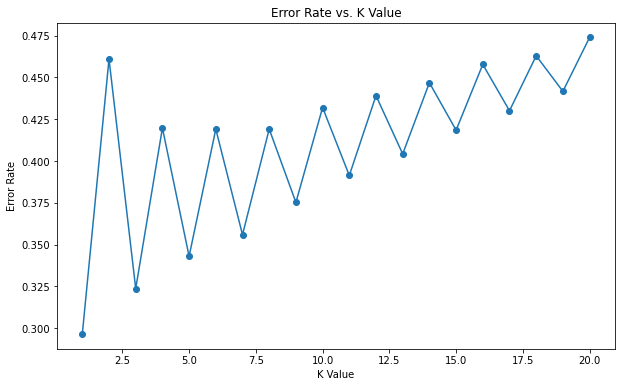

Best value of K: 1


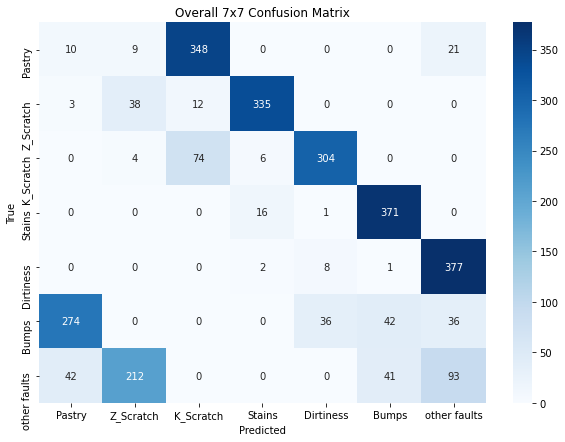

Overall Accuracy: 0.7242
Overall Precision (Macro avg): 0.7527
Overall Recall (Macro avg): 0.7472
Overall F1 Score (Macro avg): 0.7448


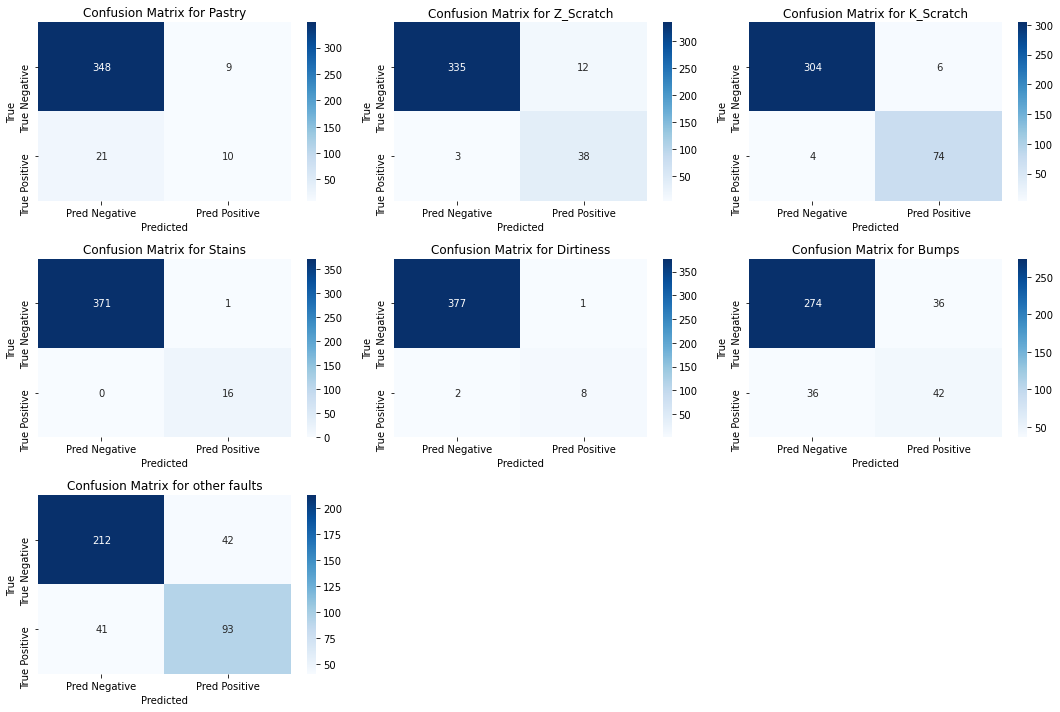

Metrics for Pastry:
Accuracy: 0.9227
Precision: 0.5263
Recall: 0.3226


Metrics for Z_Scratch:
Accuracy: 0.9613
Precision: 0.7600
Recall: 0.9268


Metrics for K_Scratch:
Accuracy: 0.9742
Precision: 0.9250
Recall: 0.9487


Metrics for Stains:
Accuracy: 0.9974
Precision: 0.9412
Recall: 1.0000


Metrics for Dirtiness:
Accuracy: 0.9923
Precision: 0.8889
Recall: 0.8000


Metrics for Bumps:
Accuracy: 0.8144
Precision: 0.5385
Recall: 0.5385


Metrics for other faults:
Accuracy: 0.7861
Precision: 0.6889
Recall: 0.6940




In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_excel('faults.xlsx')  # Adjust file path if needed

# Define the feature columns and the target columns
feature_columns = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 
                   'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 
                   'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 
                   'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 
                   'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 
                   'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']

target_columns = ['Pastry', 'Z_Scratch', 'K_Scratch', 'Stains', 'Dirtiness', 'Bumps', 'other faults']

# Separate features (X) and targets (y)
X = df[feature_columns]
y = df[target_columns]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler to the continuous feature columns only (excluding binary columns)
continuous_columns = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 
                      'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 
                      'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 
                      'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 
                      'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 
                      'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']

# Apply scaling only to continuous columns
scaler = StandardScaler()

# Ensure that we are working with the original DataFrame when modifying it
X_train = X_train.copy()  # Make a copy to avoid warnings
X_test = X_test.copy()    # Make a copy to avoid warnings

# Apply scaling to the continuous columns
X_train.loc[:, continuous_columns] = scaler.fit_transform(X_train.loc[:, continuous_columns])
X_test.loc[:, continuous_columns] = scaler.transform(X_test.loc[:, continuous_columns])

# Initialize K-NN classifier
knn = KNeighborsClassifier()

# Train K-NN classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# K-NN Optimization: Choose the best K by testing different values of K
k_values = range(1, 21)
cv_scores = []

# Cross-validation to find the optimal value of K
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))

# Plot error rates vs. K values
plt.figure(figsize=(10, 6))
plt.plot(k_values, [1 - score for score in cv_scores], marker='o')
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.show()

# Find the best K
best_k = k_values[np.argmin([1 - score for score in cv_scores])]
print(f"Best value of K: {best_k}")

# Re-train the model with the optimal K
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Re-evaluate the model with the best K
y_pred_best_k = knn.predict(X_test)

# Generate the confusion matrix for all target columns
overall_cm = np.zeros((7, 7))

# Loop over each target and create a confusion matrix
for i in range(y.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_best_k[:, i])
    overall_cm[i, i] = cm[1, 1]  # True Positives
    overall_cm[i, (i+1)%7] = cm[0, 1]  # False Positives
    overall_cm[i, (i-1)%7] = cm[1, 0]  # False Negatives
    overall_cm[i, (i+2)%7] = cm[0, 0]  # True Negatives

# Plot the 7x7 confusion matrix (heatmap)
plt.figure(figsize=(10, 7))
sns.heatmap(overall_cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_columns, yticklabels=target_columns)
plt.title('Overall 7x7 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate overall metrics (accuracy, precision, recall, F1 score) for each target variable
overall_accuracy = accuracy_score(y_test, y_pred_best_k)
overall_precision = precision_score(y_test, y_pred_best_k, average='macro')  # Macro average for multi-class
overall_recall = recall_score(y_test, y_pred_best_k, average='macro')
overall_f1 = f1_score(y_test, y_pred_best_k, average='macro')

# Print overall metrics
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision (Macro avg): {overall_precision:.4f}")
print(f"Overall Recall (Macro avg): {overall_recall:.4f}")
print(f"Overall F1 Score (Macro avg): {overall_f1:.4f}")

# Confusion Matrix for the best K (Visualized as Heatmap)
plt.figure(figsize=(15, 10))

for i in range(y.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_best_k[:, i])
    plt.subplot(3, 3, i+1)  # Create a subplot for each target variable (up to 9)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], 
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {target_columns[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# Calculate accuracy, precision, and recall for each target variable
for i in range(y.shape[1]):
    print(f"Metrics for {target_columns[i]}:")
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred_best_k[:, i])
    precision = precision_score(y_test.iloc[:, i], y_pred_best_k[:, i])
    recall = recall_score(y_test.iloc[:, i], y_pred_best_k[:, i])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\n")
